In [29]:
import numpy as np
import pandas as pd
import random 
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

In [12]:
train = pd.read_csv('original_data.csv')
test = pd.read_csv('test.csv')
train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

In [13]:
train.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


<Axes: >

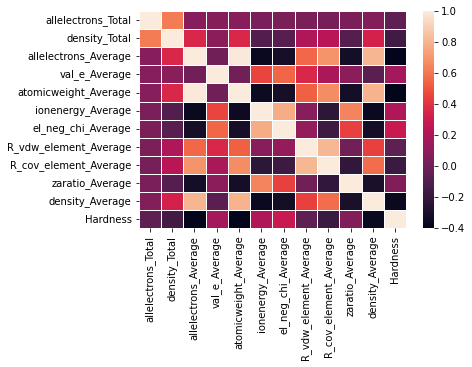

In [7]:
correlation = train.corr()
sns.heatmap(correlation, annot = False, fmt=".1f", linewidths=.8)

In [9]:
train.isnull().sum() * 100 / len(train)


allelectrons_Total       0.0
density_Total            0.0
allelectrons_Average     0.0
val_e_Average            0.0
atomicweight_Average     0.0
ionenergy_Average        0.0
el_neg_chi_Average       0.0
R_vdw_element_Average    0.0
R_cov_element_Average    0.0
zaratio_Average          0.0
density_Average          0.0
Hardness                 0.0
dtype: float64

In [10]:
test.isnull().sum() * 100 / len(test)


allelectrons_Total       0.0
density_Total            0.0
allelectrons_Average     0.0
val_e_Average            0.0
atomicweight_Average     0.0
ionenergy_Average        0.0
el_neg_chi_Average       0.0
R_vdw_element_Average    0.0
R_cov_element_Average    0.0
zaratio_Average          0.0
density_Average          0.0
dtype: float64

In [11]:
numerical_features = [ 'allelectrons_Total',	'density_Total',
                      	'allelectrons_Average',	'val_e_Average',
                            'atomicweight_Average',	'ionenergy_Average',
                                'el_neg_chi_Average',	'R_vdw_element_Average',
                                    'R_cov_element_Average',	'zaratio_Average',
                                        'density_Average']
label = 'Hardness'

In [17]:
### Using functions from kaggle[...]/thiagostat/appyling-feat-eng-xgboost-optuna
def create_product_columns(df):
    new_cols = {}
    columns = df.columns
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            new_col_name = f"{columns[i]}_x_{columns[j]}"
            new_cols[new_col_name] = df[columns[i]] * df[columns[j]]

    new_cols_df = pd.DataFrame(new_cols)

    return new_cols_df

In [16]:
### Using functions from kaggle[...]/thiagostat/appyling-feat-eng-xgboost-optuna
def create_ratio_columns(df):
    new_cols = {}
    columns = df.columns
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            new_col_name = f"{columns[i]}_:_{columns[j]}"
            new_cols[new_col_name] = df[columns[i]] / df[columns[j]]

    new_cols_df = pd.DataFrame(new_cols)
  
    return new_cols_df

In [18]:
train_product = create_product_columns(train[numerical_features])
test_product = create_product_columns(test[numerical_features])

train_ratio = create_ratio_columns(train[numerical_features])
test_ratio = create_ratio_columns(test[numerical_features])

In [19]:
train = pd.concat([train, train_product, train_ratio], axis=1)
test = pd.concat([test, test_product, test_ratio], axis=1)

In [20]:
numumerical_features = numerical_features + list(train_product.columns.values) + list(train_ratio.columns.values)

In [23]:
### Replacing all NaN and inf with 0 - results from total electrons = 0.
train.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
test.replace([np.inf, -np.inf, np.nan], 0, inplace=True)


In [26]:
train.to_csv("train.csv")

In [27]:
train.describe()


,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,...,el_neg_chi_Average_:_R_vdw_element_Average,el_neg_chi_Average_:_R_cov_element_Average,el_neg_chi_Average_:_zaratio_Average,el_neg_chi_Average_:_density_Average,R_vdw_element_Average_:_R_cov_element_Average,R_vdw_element_Average_:_zaratio_Average,R_vdw_element_Average_:_density_Average,R_cov_element_Average_:_zaratio_Average,R_cov_element_Average_:_density_Average,zaratio_Average_:_density_Average
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,...,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,...,1.510266,2.843501,5.281841,2.674267,1.850805,3.530468,1.661843,1.936127,0.860216,0.528544
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,...,0.258518,0.706950,0.750760,8.259226,0.281197,0.582223,4.701450,0.472481,2.325828,1.806731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,...,1.412576,2.488321,4.936180,0.907512,1.750000,3.376912,0.611635,1.757905,0.338821,0.163582
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,...,1.587140,2.985491,5.470916,1.928573,1.874730,3.551598,1.255715,1.884458,0.666507,0.354811
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,...,1.667638,3.200187,5.719222,3.325348,1.961877,3.783375,2.060423,2.060842,1.080460,0.604882
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,...,2.559809,17.277778,7.484701,271.238801,12.055556,5.222403,160.024714,3.734734,88.971270,70.655113


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)